In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import time
import pickle

In [2]:
##      데이터 전처리 함수
def data_preprocess(directory):
    df = pd.read_csv(directory)
    df = df[['Time','open','volume']]
    df['Time'] = pd.to_datetime(df['Time'])  # datetime 형식으로 변환
    df.set_index('Time', inplace=True)

    df['openChange'] = (df['open'] - df['open'].shift(1)) / df['open'].shift(1) * 100
    df['openChange'] = df['openChange'].round(2)
    df['openChange'].fillna(0, inplace=True)

    df['volumeRound'] = df['volume'].round()
    
    print(df)
    print(len(df))

    return df

In [3]:
action_list = []

actions_dictionary = {
    0: "매수",
    1: "홀딩",
    2: "매도"
}

def action_choose(bank_account, stock_account, open_price):
  if bank_account >= open_price:
    if stock_account > 0 :
      action_list = [0,1,2]
    else:
      action_list = [0,1]

  else :
    if stock_account > 0 :
      action_list = [1,2]
    else:
      action_list = [1]

  return action_list

def stock_action(action, bank_account, stock_account, stock_account_number, open_price, account_sum):
  if action == 0:                                           # 매수
    number_stock = 1                                        # 매수할 주식 수
    amount_stock = number_stock * open_price                # 총 매수 금액
    charge_fee = 0                                         # 수수료
    bank_account = bank_account - amount_stock * (1 + charge_fee) # 예수금 잔액
    stock_account_number += number_stock                    # 보유 주식 수
    stock_account = open_price * stock_account_number       # 주식 잔고 잔액
    
  elif action == 1:                                         # 홀딩
    # bank_account = bank_account
    # stock_account = stock_account_number * open_price
    pass
  
  elif action == 2:                                         # 매도
    amount_stock = 1 * open_price                           # 매도할 주식 금액
    charge_fee = 0                                        # 수수료
    bank_account = bank_account + amount_stock * (1-charge_fee) # 예수금 잔액
    stock_account_number -= 1                               # 보유 주식 수
    stock_account = stock_account_number * open_price       # 주식 잔고 잔액
  
  account_sum = bank_account + stock_account
  return bank_account, stock_account, stock_account_number, account_sum

def states_maker(df, observeColumn, minute):
  open_change = df[observeColumn]
  states = []
  num_rows = len(open_change)
  volume_round = df['volumeRound']

  for i in range(num_rows):
    if i < minute - 1:
      state = (0,) * (minute - 1 - i) + tuple(open_change[:i + 1]) + (0,) * (minute - 1 - i) + tuple(volume_round[:i])
      states.append(state)
    else:
      state = tuple(open_change[i - minute + 1:i + 1]) + tuple(volume_round[i - minute + 1:i],)
      # state = state + tuple(volume_round[i - minute + 1:i],)
      states.append(state)

  df['state'] = states
  print(df)
  
  return states

def reset_bank_account(initial_bank_account):
  bank_account = initial_bank_account
  initial_bank_account = initial_bank_account
  stock_account = 0
  stock_account_number = 0
  account_sum = 0
  save_money = 0

  return bank_account, initial_bank_account, stock_account, stock_account_number, account_sum, save_money

def sort_key(state_to_index):
    return (state_to_index[4], state_to_index[2], state_to_index[3], state_to_index[1], state_to_index[0])

def find_insert_index(sorted_states, new_state):
    new_state_key = sort_key(new_state)
    for index, state in enumerate(sorted_states):
        if sort_key(state) < new_state_key:
            return index
    return len(sorted_states)

In [4]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def add(self, experience):
    self.buffer.append(experience)

  def sample_recent(self, num_samples):
    return list(self.buffer)[-num_samples:] if len(self.buffer) >= num_samples else list(self.buffer)

In [5]:
def Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A):
  next_q_values = Q[next_state_index]
  target = reward + gamma * np.max(next_q_values)
  
  V[current_state_index] = np.mean(Q[current_state_index])
  A[current_state_index, action] = target - V[current_state_index]
  Q[current_state_index, action] += alpha * (V[current_state_index] + A[current_state_index, action] - Q[current_state_index, action])

In [6]:
alpha = 1.0               # 학습률 : 0 ~ 1 = 보수 ~ 진보
gamma = 0.8               # 할인률 : 0 ~ 1 = 단타 ~ 장타
epsilon = 0.0
episodes = 1000
# batch_size = 16
temp_reward_avg = 0
best_reward_episode = 0
buffer_capacity = 10

initial_bank_account= 40000000
valid_initial_bank_account = 90000000
minute = 3
observe_column = 'openChange'
average_minute = 60

file_path = 'D:/StockQ-Learning/bitcoinTicker10000.csv'#'D:/StockQ-Learning/bitcoin_data(2020-12-05).csv'
valid_file_path = 'D:/StockQ-Learning/bitcoinTicker1000.csv'

Q_directory = 'q_table.npy'

In [7]:
df = data_preprocess(file_path)

index_list = df.index.tolist()
open_price = df['open'].tolist()

rewards = []
avg_rewards = []
states = states_maker(df, observe_column, minute)

unique_states = list(set(states))
num_states = len(unique_states)
state_to_index = {state: idx for idx, state in enumerate(unique_states)}
state_to_index = sorted(state_to_index.keys(), key=sort_key, reverse=True)
state_to_index = {state: index for index, state in enumerate(state_to_index)}

print(f'데이터프레임 길이 : {len(df)}, 인덱스 길이 : {len(state_to_index)}')

Q = np.random.rand(len(unique_states), 3) * 0.01
V = np.random.rand(len(unique_states)) * 0.01
A = np.random.rand(len(unique_states), 3) * 0.01

print(state_to_index)

with open('states_to_index.pkl', 'wb') as f:
    pickle.dump(state_to_index, f)

                           open     volume  openChange  volumeRound
Time                                                               
2023-08-19 00:13:00  35770000.0  10.617117        0.00         11.0
2023-08-19 00:14:00  35811000.0   2.585002        0.11          3.0
2023-08-19 00:15:00  35793000.0   7.475726       -0.05          7.0
2023-08-19 00:16:00  35821000.0  13.761067        0.08         14.0
2023-08-19 00:17:00  35845000.0   7.137160        0.07          7.0
...                         ...        ...         ...          ...
2023-08-25 22:55:00  35499000.0   1.653217       -0.06          2.0
2023-08-25 22:56:00  35490000.0   0.854539       -0.03          1.0
2023-08-25 22:57:00  35495000.0   0.870282        0.01          1.0
2023-08-25 22:58:00  35494000.0   0.668910       -0.00          1.0
2023-08-25 22:59:00  35484000.0   3.361066       -0.03          3.0

[10007 rows x 4 columns]
10007
                           open     volume  openChange  volumeRound  \
Time         

Q-Learning

In [8]:
for episode in range(episodes):
  if episode == 11:
    start_time = time.time()
  state = (0,0,0,0,0)
  replay_buffer = ReplayBuffer(buffer_capacity)
  reward = 0
  bank_account, initial_bank_account, stock_account, stock_account_number, account_sum, save_money = reset_bank_account(initial_bank_account)
  
  for i in range(0, len(index_list)):
    current_state_index = state_to_index[state]
    
    if random.uniform(0, 1) < epsilon:
      action_list = action_choose(bank_account, stock_account, open_price[i])
      action = random.choice(action_list)
    else:
      # action = np.argmax(Q[current_state_index])
      valid_actions = action_choose(bank_account, stock_account, open_price[i])
      action_values = [Q[current_state_index, a] for a in valid_actions]
      max_action_index = np.argmax(action_values)
      # print(max_action_index)
      action = valid_actions[max_action_index]
    
    if i < len(states) - 1:
      next_state = states[i+1]
    else:
      break

    bank_account, stock_account, stock_account_number, account_sum = stock_action(action, bank_account, stock_account, stock_account_number, open_price[i], account_sum)
    
    if bank_account > open_price[i] + 10000000:
      save_money += bank_account - open_price[i] - 10000000
      bank_account -= bank_account - open_price[i] - 10000000
    
    account_sum += save_money
    
    rate = (account_sum - initial_bank_account) / initial_bank_account * 100
    reward = rate
    # print(f'회차 : {i}, 액션:{actions_dictionary[action]}, 저축 : {save_money}, 시가:{open_price[i]},예수금:{bank_account}, 주식잔고:{stock_account}, 보유주식수:{stock_account_number}, 계좌총액:{account_sum}, 수익률:{rate}')
    next_state_index = state_to_index[next_state]
    
    experience = (current_state_index, action, reward, next_state_index)
    replay_buffer.add(experience)
    
    # Q[current_state_index, action] += alpha * (reward + gamma * np.max(Q[next_state_index]) - Q[current_state_index, action])
    
    Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A)
    
    if len(replay_buffer.buffer) >= 10:
      recent_experiences = replay_buffer.sample_recent(10)
      for experience in recent_experiences:
        current_state_index, action, reward, next_state_index = experience
        Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A)
    
    state = next_state

  alpha = max(0.01, (episodes - episode) / episodes)
  
  rewards.append(reward)
  avg_reward = np.mean(rewards[-average_minute:])
  avg_rewards.append(avg_reward)
  
  if avg_reward >= temp_reward_avg:
    BEST_Q = Q
    print(f'최고 수익률 업데이트 : {temp_reward_avg:.2f}%  ->  {avg_reward:.2f}%')
    temp_reward_avg = avg_reward
    best_reward_episode = episode

  print(f'episode : {episode}, reward : {reward:.2f}, epsilon : {epsilon}, alpha : {alpha}')
  if episode == 11:
    end_time = time.time()
    execution_time = (end_time - start_time) * (episodes-episode)
    minutes = int(execution_time // 60)
    seconds = execution_time % 60
    time_to_end = f"** 예상 남은 시간: {minutes}분 {seconds:.3f}초 **"
    time_length = len(time_to_end) + 8
    print("*" * time_length)
    print(time_to_end)
    print("*" * time_length)
  # input()
np.save(Q_directory, BEST_Q)
print(f'최종 저장된 에피소드 : {best_reward_episode}, 수익율 : {temp_reward_avg}')

episode : 0, reward : -4.73, epsilon : 0.0, alpha : 1.0
episode : 1, reward : -0.53, epsilon : 0.0, alpha : 0.999
episode : 2, reward : 3.33, epsilon : 0.0, alpha : 0.998
최고 수익률 업데이트 : 0.00%  ->  0.04%
episode : 3, reward : 2.10, epsilon : 0.0, alpha : 0.997
최고 수익률 업데이트 : 0.04%  ->  0.39%
episode : 4, reward : 1.77, epsilon : 0.0, alpha : 0.996
episode : 5, reward : 0.03, epsilon : 0.0, alpha : 0.995
episode : 6, reward : -0.56, epsilon : 0.0, alpha : 0.994
episode : 7, reward : 0.45, epsilon : 0.0, alpha : 0.993
episode : 8, reward : 0.08, epsilon : 0.0, alpha : 0.992
episode : 9, reward : -3.28, epsilon : 0.0, alpha : 0.991
episode : 10, reward : -0.35, epsilon : 0.0, alpha : 0.99
episode : 11, reward : -0.28, epsilon : 0.0, alpha : 0.989
**********************************
** 예상 남은 시간: 13분 6.241초 **
**********************************
episode : 12, reward : -1.32, epsilon : 0.0, alpha : 0.988
episode : 13, reward : -2.48, epsilon : 0.0, alpha : 0.987
episode : 14, reward : -1.35, epsi

Rewards 시각화

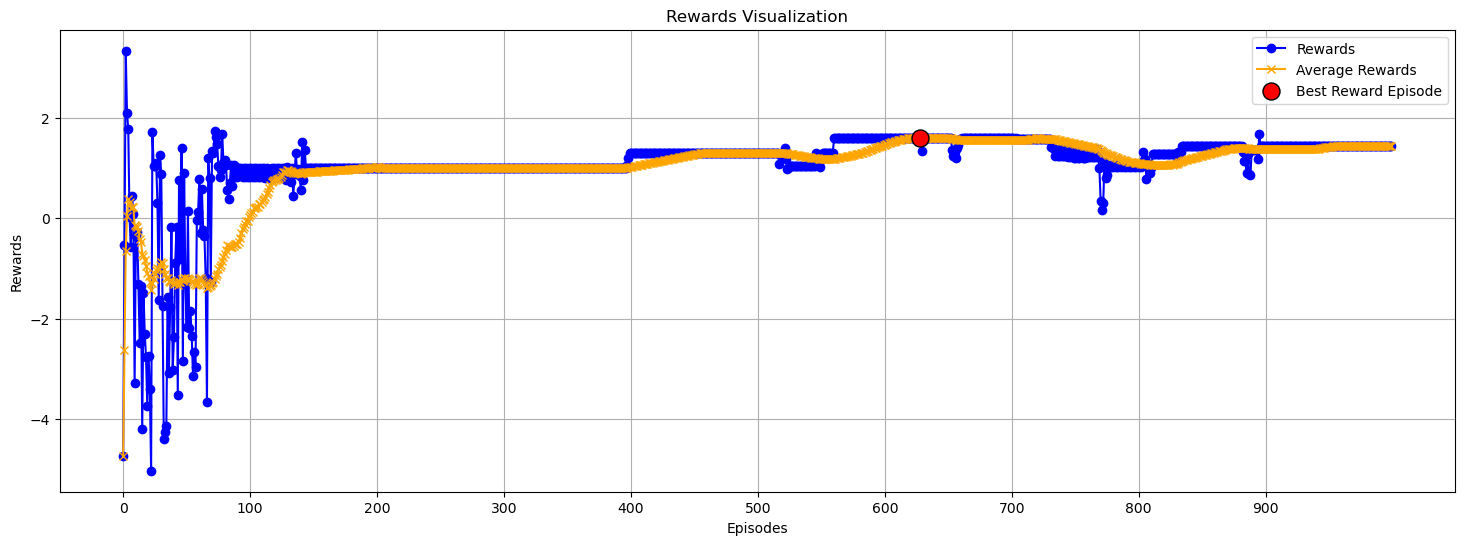

In [9]:
x = range(len(rewards))

plt.figure(figsize=(18, 6))
plt.plot(x, rewards, marker='o', label='Rewards', color='blue')
plt.plot(x, avg_rewards, marker='x', label='Average Rewards', color='orange')

plt.xticks(ticks=range(0, len(rewards), len(rewards) // 10))

best_avg_reward = avg_rewards[best_reward_episode]
plt.scatter(best_reward_episode, best_avg_reward, color='red', s=150, label='Best Reward Episode', edgecolor='black', zorder=5)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards Visualization')

plt.legend()
plt.grid()
plt.show()

모의 투자

In [10]:
Q_table = np.load(Q_directory)

def trading_simulation(valid_file_path, Q_table, state_to_index, valid_initial_bank_account):
  valid_df = data_preprocess(valid_file_path)
  valid_states= states_maker(valid_df, observe_column, minute)

  bank_account, initial_bank_account, stock_account, stock_account_number, account_sum = reset_bank_account(valid_initial_bank_account)
  action_list = []

  buy_sum, hold_sum, sell_sum = 0, 0, 0

  for index, row in valid_df.iterrows():
    open_price = row['open']
    current_state = row['state']
    try:
      current_state_index = state_to_index[current_state]
    except KeyError:
      current_state_index  = find_insert_index(state_to_index, current_state)
      if current_state_index >= len(state_to_index):
        current_state_index -= 1 
    q_value = Q_table[current_state_index]
    q_value_sorted = np.argsort(q_value)[::-1]
    action_list = action_choose(bank_account, stock_account, open_price)
    
    if q_value_sorted[0] in action_list:
      action = q_value_sorted[0]
    elif q_value_sorted[0] not in action_list:
      if q_value_sorted[1] in action_list:
        action = q_value_sorted[1]
      elif q_value_sorted[1] not in action_list:
        action = q_value_sorted[2]
    
    
    bank_account, stock_account, stock_account_number, account_sum = stock_action(action, bank_account, stock_account, stock_account_number, open_price, account_sum)
    rate = (account_sum - initial_bank_account) / initial_bank_account * 100

    if action == 0:
      buy_sum += 1
    elif action == 1:
      hold_sum += 1
    else:
      sell_sum += 1
    
    print(f'시간:{index}, 액션:{actions_dictionary[action]}, 시가:{open_price},예수금:{bank_account}, 주식잔고:{stock_account}, 보유주식수:{stock_account_number}, 계좌총액:{account_sum}, 수익률:{rate}')

  rate_buy = round((buy_sum / len(valid_df)*100),2)
  rate_hold = round((hold_sum / len(valid_df)*100),2)
  rate_sell = round((sell_sum / len(valid_df)*100),2)

  print(f'매수 비율 : {rate_buy}%, 홀드 비율 : {rate_hold}%, 매도 비율 : {rate_sell}%,')

trading_simulation(valid_file_path, Q_table, state_to_index, valid_initial_bank_account)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/StockQ-Learning/bitcoinTickerETHValid100000.csv'